# 311 Service Request Data Exploration and Analysis

## Findings from Exploratory Analysis (Assumptions / Things to Note)

- We are not considering two specific service request types (sr_type) in our data:
    1. 311 Informational Calls: this is a 311 Call Center. These requests are informational not relevant to our analysis.
    2. aircraft noise complaint: this maps to the Aviation Administration building, and exclusively deals with aircraft noise complaints. This is either geo-tagged to a single building and doesn't provide required variation across neighborhoods or are all completed within 10s - which points to an automated log. 
    
- We have removed rows where service resolution time <= 0. These are mainly due to data anomalies.
    
- Resolution times have been bucketed in such a way that:
    1. Each time-period bucket has similar number of complaints
    2. They make more logical/real-world sense for analysis (For eg: service resolution within 1 hour is very different from service resolution in 12 hours)
    
- From amongst the unresolved service requests, below are the ones that have highest percentage of unresolved each year:
    - Tree Planting Request
    - Sidewalk Inspection Request
    - Lead Inspection Request
    
- From our dashboard, we can observe that...
    - in neighborhoods with a higher percentage of the population making minimal income, there are more service requests made. We see the opposite trend for high-earning neighborhoods.
    - compared to Chicago as a whole, Hyde Park's median request resolution time is now on par, as opposed to the lag in 2019.

## Importing packages and establishing connection with Chicago Data Portal

In [1]:
import pandas as pd
from sodapy import Socrata
import numpy as np
import datetime
from datetime import date
pd.set_option('display.max_rows', 1000)
pd.options.display.max_columns = None

In [2]:
socrata_domain = "data.cityofchicago.org"
socrata_dataset_identifier = "v6vf-nfxy"
app_token = "6tRoBirkYQMdr8MMFR8FzgBXq"
api_username = "v4vigtory@gmail.com"
api_password = "311_TeamVeam"

In [3]:
client = Socrata(socrata_domain, app_token, username=api_username, password=api_password)

## CDP Data Pull using Scorata API

For our initial analysis, we will look only at the 2021 Service Request Data.

In [4]:
sr_2021_sample = client.get(socrata_dataset_identifier,
                     select = '''sr_number, sr_type, sr_short_code, 
                                 owner_department, status, 
                                 created_date, closed_date, date_extract_y(created_date) as year, 
                                 street_address, city, state, zip_code, community_area, location''',
                     where = "date_extract_y(created_date) = 2021", 
                     limit = 10000000)
sr_2021_sample_df = pd.DataFrame(sr_2021_sample)

In [5]:
sr_2021_sample_df.shape

(1743647, 14)

## Exploratory Data Analysis

### Analyzing types of service requests and their location

#### Unique street_address and counts corresponding to them

In [6]:
sr_2021_sample_df.street_address.value_counts()

2111 W Lexington ST      655546
10510 W ZEMKE RD         316891
10000 W OHARE AIRPORT       313
1458 N WESTERN AVE          234
2601 N MILWAUKEE AVE        202
                          ...  
910 W 50TH PL                 1
1333 W ARGYLE ST              1
1423 S LAWNDALE AVE           1
2401 N SHEFFIELD AVE          1
1969 S TRUMBULL AVE           1
Name: street_address, Length: 361742, dtype: int64

As we can see, a **very high number of service requests are coming from 2 specific locations** in Chicago:
1. 2111 W Lexington ST
2. 10510 W ZEMKE RD

#### Understanding what locations the street_address with high service request numbers point to:

In [6]:
#Importing the Nominatim geocoder class 
from geopy.geocoders import Nominatim

#making an instance of Nominatim class
geolocator = Nominatim(user_agent="my_request")

In [7]:
#address we need to geocode
loc1 = "10510 W ZEMKE RD, Chicago, Illinois, 60666"
loc2 = "2111 W Lexington ST, Chicago, Illinois, 60612"

In [8]:
#applying geocode method to get the location
location = geolocator.geocode(loc1)
print(location.address)
print((location.latitude, location.longitude))

Aviation Administration Building (DOA/OMP), 10510, West Zemke Road, O'Hare, Chicago, Jefferson Township, Cook County, Illinois, 60666, United States
(41.9949158, -87.88773078235056)


In [9]:
#applying geocode method to get the location
location = geolocator.geocode(loc2)
print(location.address)
print((location.latitude, location.longitude))

311 Call Center, 2111, West Lexington Street, Illinois Medical District, Near West Side, Chicago, Cook County, Illinois, 60612, United States
(41.8719137, -87.67985041445382)


We see that both these locations are **specific buildings** in Chicago:
1. 311 Call Center
2. Aviation Administration Building

These **will not provide us the required variation in terms of spread of service requests across Community Areas**. Given their high numbers, they will skew our results.

Before removing these locations from our analysis, we will take a look at whether these locations also correspond to specific Service Request types.

#### Unqiue values of `sr_type` and counts corresponding to them:

In [10]:
sr_2021_sample_df.sr_type.value_counts()

311 INFORMATION ONLY CALL                                656348
Aircraft Noise Complaint                                 317127
Graffiti Removal Request                                  93720
Rodent Baiting/Rat Complaint                              65897
Garbage Cart Maintenance                                  54919
Street Light Out Complaint                                48420
Abandoned Vehicle Complaint                               43363
Pothole in Street Complaint                               38557
Tree Trim Request                                         32986
Weed Removal Request                                      29174
Sign Repair Request - All Other Signs                     27208
Tree Debris Clean-Up Request                              23950
Traffic Signal Out Complaint                              21399
Building Violation                                        21348
Ice and Snow Removal Request                              19306
Sanitation Code Violation               

We see that as expected from the location and the buildings, these correspond either to:
1. 311 Information only calls
2. Aviation Noise complaints - almost all specific to the Aviation Administration building.

These are also not useful for our analysis.

#### Deciding whether to filter based on `location` or `sr_type`:

In [11]:
sr_2021_sample_df['diff_mins'] = (
    pd.to_datetime(sr_2021_sample_df['closed_date']) - 
    pd.to_datetime(sr_2021_sample_df['created_date']))/np.timedelta64(1,'m')

In [12]:
sr_2021_sample_df[sr_2021_sample_df.sr_type.isin(
    ['311 INFORMATION ONLY CALL', 'Aircraft Noise Complaint'])].groupby(by = 'sr_type').diff_mins.value_counts()

sr_type                    diff_mins
311 INFORMATION ONLY CALL  0.000000     491083
                           0.016667     164969
                           0.033333        242
                           0.050000         36
                           0.066667          8
                           0.083333          6
                           0.100000          3
                           0.116667          1
Aircraft Noise Complaint   0.000000     237602
                           0.016667      79367
                           0.033333        118
                           0.050000         29
                           0.066667          7
                           0.083333          2
                           0.116667          1
                           0.183333          1
Name: diff_mins, dtype: int64

We see that all of these service requests are resolved within 10 seconds, and are hence mostly automated logs, rather than actual requests that are resolved.

We can thus **remove the `sr_type` '311 INFORMATION ONLY CALL' and 'Aircraft Noise Complaint'** from our analysis dataset

### Analyzing `community_area` and `street_address` for missing values

In [14]:
sr_2021_sample_df.community_area.isna().sum()

2462

In [15]:
sr_2021_sample_df["street_address"].isna().sum()

1981

In [16]:
sr_2021_sample_df[(
    sr_2021_sample_df.community_area.isna() == False) & (sr_2021_sample_df.street_address.isna() == True)]

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,closed_date,year,street_address,city,state,zip_code,community_area,location,diff_mins
30031,SR21-01995319,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Completed,2021-11-13T16:57:48.000,2021-11-23T21:52:56.000,2021,NaN,NaN,NaN,60647,23,"{'latitude': '41.9136376036085', 'longitude': ...",14695.133333
49706,SR21-01454545,Building Violation,BBA,DOB - Buildings,Completed,2021-08-16T14:01:58.000,2021-08-17T13:48:33.000,2021,NaN,NaN,NaN,60618,5,"{'latitude': '41.93850953219724', 'longitude':...",1426.583333
153286,SR21-01522661,Report an Injured Animal,EAQ,Animal Care and Control,Completed,2021-08-26T15:18:06.000,2021-08-26T19:31:07.000,2021,NaN,NaN,NaN,60624,29,"{'latitude': '41.86597958110466', 'longitude':...",253.016667
218052,SR21-01566906,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2021-09-02T12:21:05.000,2021-09-02T13:15:02.000,2021,NaN,NaN,NaN,60647,23,"{'latitude': '41.9136376036085', 'longitude': ...",53.950000
485375,SR21-01909910,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Completed,2021-10-28T19:06:50.000,2021-11-11T06:18:54.000,2021,NaN,NaN,NaN,NaN,35,"{'latitude': '41.833663597651004', 'longitude'...",19392.066667
485568,SR21-01909975,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Completed,2021-10-28T19:28:19.000,2021-11-16T16:51:10.000,2021,NaN,NaN,NaN,NaN,25,"{'latitude': '41.894959407435735', 'longitude'...",27202.850000
485921,SR21-01910153,Traffic Signal Out Complaint,SFB,CDOT - Department of Transportation,Completed,2021-10-28T20:14:38.000,2021-10-28T21:04:08.000,2021,NaN,NaN,NaN,NaN,49,"{'latitude': '41.69265933721886', 'longitude':...",49.500000
485934,SR21-01910183,Sign Repair Request - All Other Signs,PCE,CDOT - Department of Transportation,Open,2021-10-28T20:29:31.000,NaN,2021,NaN,NaN,NaN,NaN,37,"{'latitude': '41.8137055948375', 'longitude': ...",NaN
485947,SR21-01910167,Graffiti Removal Request,GRAF,Streets and Sanitation,Canceled,2021-10-28T20:19:47.000,2021-10-29T06:14:49.000,2021,NaN,NaN,NaN,NaN,48,"{'latitude': '41.72445202141974', 'longitude':...",595.033333
486407,SR21-01910392,Street Light Out Complaint,SFD,CDOT - Department of Transportation,Completed,2021-10-28T21:47:06.000,2021-11-08T12:21:12.000,2021,NaN,NaN,NaN,NaN,8,"{'latitude': '41.91112237899331', 'longitude':...",15274.100000


We will retain these rows above, since we have their corresponding `community_area` number that will help us map them.

In [17]:
sr_2021_sample_df[(
    sr_2021_sample_df.community_area.isna() == True) & (sr_2021_sample_df.street_address.isna() == False)]

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,closed_date,year,street_address,city,state,zip_code,community_area,location,diff_mins
6,SR21-00420639,Aircraft Noise Complaint,AVN,Aviation,Completed,2021-03-13T19:36:58.000,2021-03-13T19:36:58.000,2021,10510 W ZEMKE RD,Chicago,IL,60666,NaN,NaN,0.000000
7,SR21-00420664,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2021-03-13T19:45:52.000,2021-03-13T19:45:53.000,2021,2111 W Lexington ST,Chicago,Illinois,60612,NaN,NaN,0.016667
8,SR21-00420672,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2021-03-13T19:47:58.000,2021-03-13T19:47:58.000,2021,2111 W Lexington ST,Chicago,Illinois,60612,NaN,NaN,0.000000
9,SR21-00420656,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2021-03-13T19:41:45.000,2021-03-13T19:41:45.000,2021,2111 W Lexington ST,Chicago,Illinois,60612,NaN,NaN,0.000000
10,SR21-00420677,Aircraft Noise Complaint,AVN,Aviation,Completed,2021-03-13T19:48:57.000,2021-03-13T19:48:57.000,2021,10510 W ZEMKE RD,Chicago,IL,60666,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732097,SR21-01406661,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,2021-08-09T14:59:17.000,2021-08-09T14:59:17.000,2021,2111 W Lexington ST,Chicago,Illinois,60612,NaN,"{'latitude': '41.962141282682566', 'longitude'...",0.000000
1735758,SR21-01412022,Street Light On During Day Complaint,SFN,CDOT - Department of Transportation,Open,2021-08-10T11:42:23.000,NaN,2021,7171 W NORTH AVE,NaN,NaN,NaN,NaN,"{'latitude': '41.90884646310495', 'longitude':...",NaN
1736978,SR21-01413956,Street Light Pole Door Missing Complaint,SFQ,CDOT - Department of Transportation,Open,2021-08-10T14:45:44.000,NaN,2021,7900 S CICERO AVE,NaN,NaN,0,NaN,"{'latitude': '41.749063281333775', 'longitude'...",NaN
1740782,SR21-01419862,Traffic Signal Out Complaint,SFB,CDOT - Department of Transportation,Completed,2021-08-11T10:00:36.000,2021-08-11T10:07:21.000,2021,11900 S ASHLAND AVE,NaN,NaN,60643,NaN,"{'latitude': '41.677466386334025', 'longitude'...",6.750000


In [18]:
sr_2021_sample_df[sr_2021_sample_df.street_address.isna() == False].community_area.isna().sum()

1027

We will drop these rows from our analysis, since we are unable to map them to a location and they form a very small percentage of all data.

## Creating dataset for Analyzing 311 Service Requests from 2019-2021

### API Data Pull from Chicago City Data Portal

In [13]:
sr_2021 = client.get(socrata_dataset_identifier,
                     select = '''sr_number, sr_type, sr_short_code, 
                                 owner_department, status,
                                 created_date, closed_date, date_extract_y(created_date) as year,
                                 street_address, city, state, zip_code, community_area, location''',
                     where = '''date_extract_y(created_date) = 2021 AND 
                                 community_area IS NOT NULL 
                                 AND sr_type NOT IN ('311 INFORMATION ONLY CALL', 'Aircraft Noise Complaint')''', 
                     limit = 10000000)
sr_2021_df = pd.DataFrame(sr_2021)

In [14]:
sr_2020 = client.get(socrata_dataset_identifier,
                     select = '''sr_number, sr_type, sr_short_code, 
                                 owner_department, status,
                                 created_date, closed_date, date_extract_y(created_date) as year,
                                 street_address, city, state, zip_code, community_area, location''',
                     where = '''date_extract_y(created_date) = 2020 AND 
                                 community_area IS NOT NULL AND 
                                 sr_type NOT IN ('311 INFORMATION ONLY CALL', 'Aircraft Noise Complaint')''', 
                     limit = 10000000)
sr_2020_df = pd.DataFrame(sr_2020)

In [15]:
sr_2019 = client.get(socrata_dataset_identifier,
                     select = '''sr_number, sr_type, sr_short_code,
                                 owner_department, status,
                                 created_date, closed_date, date_extract_y(created_date) as year,
                                 street_address, city, state, zip_code, community_area, location''',
                     where = '''date_extract_y(created_date) = 2019 AND 
                                 community_area IS NOT NULL AND 
                                 sr_type NOT IN ('311 INFORMATION ONLY CALL', 'Aircraft Noise Complaint')''', 
                     limit = 10000000)
sr_2019_df = pd.DataFrame(sr_2019)

In [16]:
sr_2019_21_df = pd.concat([sr_2021_df,sr_2020_df,sr_2019_df])

In [17]:
sr_2019_21_df.shape

(2415606, 14)

### Creating metrics to measure service responsiveness

In [19]:
df = sr_2019_21_df.copy()

In [20]:
# resol_time
df['diff_mins'] = (pd.to_datetime(df['closed_date']) - pd.to_datetime(df['created_date']))/np.timedelta64(1,'m')

# time_open_not_resolved
df['time_open_unresolved'] = np.where((df['diff_mins'].isna()),1, 0)

#### Sanity check to ensure the resolution time is positive:

In [21]:
df[(df.diff_mins <= 0)]

,sr_number,sr_type,sr_short_code,owner_department,status,created_date,year,street_address,zip_code,community_area,location,closed_date,city,state,diff_mins,time_open_unresolved
4,SR21-00947241,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,2021-06-04T10:31:54.000,2021,2707 N MILWAUKEE AVE,60647,22,"{'latitude': '41.93039087', 'longitude': '-87....",2021-06-04T10:31:54.000,NaN,NaN,0.0,0
1016,SR21-01426096,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2021-08-11T19:54:36.000,2021,77 E WASHINGTON ST,60602,32,"{'latitude': '41.88320542906238', 'longitude':...",2021-08-11T19:54:36.000,NaN,NaN,0.0,0
1023,SR21-01426143,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2021-08-11T20:02:52.000,2021,847 N MILWAUKEE AVE,60642,24,"{'latitude': '41.89731790456385', 'longitude':...",2021-08-11T20:02:52.000,NaN,NaN,0.0,0
1074,SR21-01426173,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2021-08-11T20:04:35.000,2021,2226 N ELSTON AVE,60614,22,"{'latitude': '41.92196553174694', 'longitude':...",2021-08-11T20:04:35.000,NaN,NaN,0.0,0
1304,SR21-01426390,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2021-08-11T20:36:51.000,2021,2277 N ELSTON AVE,60614,22,"{'latitude': '41.92313524764981', 'longitude':...",2021-08-11T20:36:51.000,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808850,SR19-03203256,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2019-12-26T12:32:25.000,2019,3880 N MILWAUKEE AVE,60641,15,"{'latitude': '41.95160529679968', 'longitude':...",2019-12-26T12:32:25.000,NaN,NaN,0.0,0
809325,SR19-03206243,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2019-12-26T15:39:37.000,2019,1564 N DAMEN AVE,60622,24,"{'latitude': '41.91014546422996', 'longitude':...",2019-12-26T15:39:37.000,NaN,NaN,0.0,0
814840,SR19-03227447,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2019-12-30T13:35:41.000,2019,15 W ILLINOIS ST,60654,8,"{'latitude': '41.89074650503313', 'longitude':...",2019-12-30T13:35:41.000,NaN,NaN,0.0,0
814930,SR19-03227675,Vehicle Parked in Bike Lane Complaint,VBL,CDOT - Department of Transportation,Completed,2019-12-30T14:02:09.000,2019,437 W HARRISON ST,60607,28,"{'latitude': '41.874390487627245', 'longitude'...",2019-12-30T14:02:09.000,NaN,NaN,0.0,0


In [24]:
len(df[(df.diff_mins <= 0)])/(len(df))*100

0.15627548532335156

In [25]:
df[(df.diff_mins <= 0)].sr_type.value_counts()

Vehicle Parked in Bike Lane Complaint    3286
E-Scooter                                 455
Extreme Weather Notification               25
Open Fire Hydrant Complaint                 3
No Water Complaint                          2
Graffiti Removal Request                    1
Vicious Animal Complaint                    1
Report an Injured Animal                    1
Traffic Signal Out Complaint                1
Name: sr_type, dtype: int64

There are 3775 rows for which the resolution time is either 0 or negative. This is a negligible number (~0.15%), and we will remove these data anomalies from the analysis

#### Creating a dataset with service requests having resolution time > 0:

In [26]:
df = df[(df.diff_mins > 0) | (df.time_open_unresolved == 1)]

#### Separating out unresolved service requests for a separate analysis

In [27]:
len(df[df.time_open_unresolved == 1])

78184

In [28]:
len(df[df.time_open_unresolved == 1])/len(df)*100

3.2416865029100297

3.27% of the total issues remain unresolved. We will separate them out for later analysis.

In [29]:
df_unresol = df[df.time_open_unresolved == 1]
df_resol = df[df.time_open_unresolved == 0]

#### Creating flag columns to bucket service complaint resolution times:

In [32]:
# time_open_less_than_1_min
df_resol['time_open_less_than_1_min'] = np.where(df_resol['diff_mins'] < 1, 1,
                                                 0)

# time_open_1_min_1_hr
df_resol['time_open_1_min_1_hr'] = np.where(
    (df_resol['diff_mins'] >= 1) & (df_resol['diff_mins'] < 60), 1, 0)

# time_open_1_hr_12_hr
df_resol['time_open_1_hr_12_hr'] = np.where(
    (df_resol['diff_mins'] >= 60) & (df_resol['diff_mins'] < 60 * 12), 1, 0)

# time_open_12_24_hr
df_resol['time_open_12_24_hr'] = np.where(
    (df_resol['diff_mins'] >= 60 * 12) & (df_resol['diff_mins'] < 60 * 24), 1,
    0)

# time_open_1_3_day
df_resol['time_open_1_3_day'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 1) &
    (df_resol['diff_mins'] < 60 * 24 * 3), 1, 0)

# time_open_3_7_day
df_resol['time_open_3_7_day'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 3) &
    (df_resol['diff_mins'] < 60 * 24 * 7), 1, 0)

# time_open_7_14_day
df_resol['time_open_7_14_day'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 7) &
    (df_resol['diff_mins'] < 60 * 24 * 14), 1, 0)

# time_open_14_30_day
df_resol['time_open_14_30_day'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 14) &
    (df_resol['diff_mins'] < 60 * 24 * 30), 1, 0)

# time_open_1_3_month
df_resol['time_open_1_3_month'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 30 * 1) &
    (df_resol['diff_mins'] < 60 * 24 * 30 * 3), 1, 0)

# time_open_3_12_month
df_resol['time_open_3_12_month'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 30 * 3) &
    (df_resol['diff_mins'] < 60 * 24 * 30 * 12), 1, 0)

# time_open_1_year_plus
df_resol['time_open_1_year_plus'] = np.where(
    (df_resol['diff_mins'] >= 60 * 24 * 30 * 12), 1, 0)
;

/var/folders/8g/3jp0k1x54d1f91mld1sc5gq80000gn/T/ipykernel_34212/2518727198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resol['time_open_less_than_1_min'] = np.where(df_resol['diff_mins'] < 1, 1,
/var/folders/8g/3jp0k1x54d1f91mld1sc5gq80000gn/T/ipykernel_34212/2518727198.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resol['time_open_1_min_1_hr'] = np.where(
/var/folders/8g/3jp0k1x54d1f91mld1sc5gq80000gn/T/ipykernel_34212/2518727198.py:10: SettingWithCopyWarning: 
A value is trying to be 

''

#### Comparing number of service requests under each time-period bucket

In [33]:
df_time_bucket_perc = df_resol[['time_open_less_than_1_min', 'time_open_1_min_1_hr', 'time_open_1_hr_12_hr', 'time_open_12_24_hr',
    'time_open_1_3_day', 'time_open_3_7_day', 'time_open_7_14_day','time_open_14_30_day', 'time_open_1_3_month', 
    'time_open_3_12_month','time_open_1_year_plus']].aggregate(np.mean, axis = 0).reset_index()

df_time_bucket_perc = df_time_bucket_perc.rename(columns = {'index':'time_bucket', 0:'perc_sr'})
df_time_bucket_perc['perc_sr'] = df_time_bucket_perc['perc_sr']*100
df_time_bucket_perc

,time_bucket,perc_sr
0,time_open_less_than_1_min,11.003378
1,time_open_1_min_1_hr,6.503169
2,time_open_1_hr_12_hr,6.913642
3,time_open_12_24_hr,8.063088
4,time_open_1_3_day,13.134206
5,time_open_3_7_day,11.087110
6,time_open_7_14_day,9.355357
7,time_open_14_30_day,10.706932
8,time_open_1_3_month,12.780896
9,time_open_3_12_month,8.861837


## Bringing in census data

In [34]:
census_pop_data = pd.read_csv("../data/census_demos_pop.csv", index_col = 0)
census_demo_data = pd.read_csv("../data/census_demos.csv", index_col = 0)

In [35]:
census_demo_data

,cca_name,cca_num,percent_unemployed,LTM_income_sub_10k,LTM_income_10-15k,LTM_income_15_20k,LTM_income_20_25k,LTM_income_25_30k,LTM_income_30_35k,LTM_income_35_40k,LTM_income_40_45k,LTM_income_45_50k,LTM_income_50_60k,LTM_income_60_75k,LTM_income_75_100k,LTM_income_100_125k,LTM_income_125_150k,LTM_income_150_200k,LTM_income_200k+,below_0.50_poverty_line,0.50_1.00_poverty_line,1.00_1.25_poverty_line,1.25_1.50_poverty_line,1.50_1.85_poverty_line,1.85_2.00_poverty_line,2.00+_poverty_line,White,Black_or_African_American,American_Indian_or_Alaska_Native,Asian,Native_Hawaiian_or_Other_Pacific_Islander,some_other_race_alone,two_or_more_races
0,Rogers Park,1,9.765415,12.997481,7.031906,7.716205,7.594458,6.498741,5.377834,6.259446,4.130982,3.639798,7.791772,8.727960,8.933669,5.570949,2.787573,2.938707,2.002519,11.657890,14.647942,7.031402,6.805149,6.588648,3.604447,49.664521,59.486784,25.287673,0.231609,6.475865,0.000000,4.635859,3.882210
1,West Ridge,2,8.842689,9.436204,4.039990,7.563714,6.125543,4.818487,5.502745,5.797755,5.715808,4.580841,7.686634,8.166025,10.944030,8.002131,4.552159,3.667131,3.400803,9.592124,12.475387,6.406470,7.675105,6.351617,4.078762,53.420534,57.607567,11.600726,0.301893,23.514423,0.000000,3.542397,3.432995
2,Uptown,3,9.804309,15.620403,6.688105,6.072320,5.524956,4.686805,4.132599,2.894188,3.951285,3.020766,6.469159,7.546783,11.097807,7.984674,3.574972,4.649174,6.086005,10.189732,13.857887,4.334077,4.828869,6.309524,1.272321,59.207589,62.818071,21.158206,0.275677,8.761811,0.083429,3.213813,3.688993
3,Lincoln Square,4,7.199730,6.996110,3.900729,4.525284,4.152742,4.426670,3.467923,4.519805,4.563633,4.317099,6.963239,11.077631,12.222648,8.316441,5.812743,6.201720,8.535583,6.633148,5.306519,4.487642,3.584140,5.037708,1.792070,73.158772,76.428449,3.741321,0.284586,11.116018,0.000000,5.012144,3.417482
4,North Center,5,4.236298,3.554975,1.499003,2.289761,2.832978,2.097229,3.273052,2.860483,3.396823,3.080520,5.693461,10.142337,13.133466,11.435055,7.247473,9.262188,18.201196,2.727956,2.820528,1.750174,2.930456,3.778061,0.465749,85.527077,87.863559,2.024666,0.147301,4.369928,0.000000,1.946683,3.647864
5,Lake View,6,3.666862,6.593134,3.148675,2.892964,2.925405,3.083793,2.793733,3.444459,4.301280,3.137225,6.896552,9.871572,12.285556,10.751293,6.411847,7.419423,14.043089,6.244578,4.424986,2.418639,2.139016,3.172805,1.019502,80.580473,85.403006,3.545392,0.218914,6.899361,0.016291,1.100680,2.816356
6,Lincoln Park,7,4.181882,7.398730,3.745607,2.786855,2.034651,1.421173,2.857759,1.951415,3.095135,1.979160,5.644614,8.228004,11.600592,10.127012,7.232258,10.345891,19.551144,6.165449,4.647655,1.561788,1.624637,2.741771,0.824888,82.433813,85.877925,4.858197,0.062725,5.666154,0.031362,0.831852,2.671784
7,Near North Side,8,6.301068,9.400342,3.135927,2.795551,2.832751,2.018079,3.254966,2.138978,2.462614,2.036679,6.126776,8.736329,12.683208,9.657020,5.174466,8.924187,18.622126,7.913078,4.452149,3.074925,2.061070,2.074175,0.446764,79.977841,74.981041,9.515698,0.418849,11.475773,0.000000,1.424555,2.184084
8,Edison Park,9,5.009482,1.865423,1.709971,2.353986,2.265157,2.442816,5.574062,4.574728,4.063957,2.975794,6.351321,8.416611,16.500111,10.015545,6.573396,12.591606,11.725516,0.678056,1.268052,1.268052,2.800282,2.615358,1.083128,90.287073,95.227193,1.056710,0.000000,1.470588,0.000000,1.135963,1.109546
9,Norwood Park,10,6.915254,5.722653,3.337197,4.057105,3.349399,3.404307,2.867427,4.722104,4.002196,2.910134,7.235678,9.578427,13.684339,12.854615,6.930633,7.912879,7.430907,2.886351,3.413361,1.483433,3.105939,3.428000,1.546870,84.136046,89.059524,0.933002,0.127776,4.204537,0.038574,2.972589,2.663999


## Analysis of Unresolved Requests

In [36]:
# create column 'time_open'
df_unresol['time_open'] = ((pd.to_datetime("today")) - pd.to_datetime(df_unresol['created_date']))/np.timedelta64(1,'m')
;

/var/folders/8g/3jp0k1x54d1f91mld1sc5gq80000gn/T/ipykernel_34212/3678892106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unresol['time_open'] = ((pd.to_datetime("today")) - pd.to_datetime(df_unresol['created_date']))/np.timedelta64(1,'m')


''

In [37]:
df_unresol['community_area'] = df_unresol['community_area'].astype(int)
df['community_area'] = df['community_area'].astype(int)
;

/var/folders/8g/3jp0k1x54d1f91mld1sc5gq80000gn/T/ipykernel_34212/1418158018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unresol['community_area'] = df_unresol['community_area'].astype(int)


''

#### Unresolved issues by year

In [38]:
df_unresol.year.value_counts()

2021    53479
2020    17757
2019     6948
Name: year, dtype: int64

Understandably, there are more unresolved issues in 2021 than in 2020, which is greater than ones in 2019. The older requests simply have more time to allow the requests to close.

#### Unresolved service requests across community :

In [39]:
df_unresol_by_cca = df_unresol.groupby(['year','community_area']).agg(tot_unresol = ('sr_number', len))
df_totreq_by_cca = df.groupby(['year','community_area']).agg(tot_req = ('sr_number', len))

df_unresol_perc_cca = pd.merge(df_unresol_by_cca, 
                   df_totreq_by_cca, 
                   left_on = ['year','community_area'],
                   right_on = ['year','community_area'],
                   how='left')

df_unresol_perc_cca['perc_unresol'] = (df_unresol_perc_cca['tot_unresol']/df_unresol_perc_cca['tot_req'])*100
df_unresol_perc_cca.sort_values(['year','perc_unresol'], ascending = [True, False])

tot_unresol  tot_req  perc_unresol
year community_area                                    
2019 9                        91     3576      2.544743
     16                      312    18245      1.710058
     8                       206    12605      1.634272
     12                      124     7626      1.626016
     32                      137     8456      1.620151
     3                       134     8560      1.565421
     4                       154     9946      1.548361
     5                       176    11398      1.544131
     10                      185    12100      1.528926
     13                       74     5112      1.447574
     11                      119     8457      1.407118
     60                      109     7980      1.365915
     15                      252    18770      1.342568
     41                       53     3961      1.338046
     33                       43     3255      1.321045
     7                       183    14254      1.283850
     17                      165    13179      1.251992
     22                      285    22815      1.249178
     77                      128    10445      1.225467
     56                      150    12699      1.181195
     6                       228    20243      1.126315
     72                       93     8432      1.102941
     14                      119    10853      1.096471
     2                       174    16111      1.080007
     24                      283    27034      1.046830
     35                       32     3067      1.043365
     64                       89     8706      1.022283
     62                       49     4907      0.998573
     57                       44     4536      0.970018
     65                       83     8665      0.957877
     21                      107    11810      0.906012
     55                       44     5052      0.870942
     34                       23     2739      0.839723
     28                      150    18134      0.827175
     48                       52     6338      0.820448
     74                       50     6118      0.817261
     36                       11     1370      0.802920
     20                       43     5517      0.779409
     76                       17     2225      0.764045
     1                        62     8177      0.758224
     30                      134    17873      0.749734
     52                       57     7702      0.740068
     70                      101    14345      0.704078
     75                       75    10680      0.702247
     42                       49     7136      0.686659
     66                       87    14590      0.596299
     29                      101    17056      0.592167
     19                      100    17499      0.571461
     71                      101    17783      0.567958
     23                      100    17623      0.567440
     37                       12     2119      0.566305
     45                       26     4611      0.563869
     31                       68    12161      0.559165
     44                       68    12294      0.553115
     27                       54     9883      0.546393
     25                      161    29508      0.545615
     73                       67    12312      0.544185
     49                      106    20536      0.516167
     39                       15     2930      0.511945
     69                       71    14268      0.497617
     58                       56    11353      0.493262
     43                       65    13208      0.492126
     18                       18     3790      0.474934
     59                       35     7556      0.463208
     46                       52    11654      0.446199
     50                       11     2577      0.426853
     61                       67    15895      0.421516
     38                       34     8250      0.412121
     63                       39     9485      0.411176
     53                       58    14510    

#### Unresolved service requests across `sr_types` and `owner_departnment`

In [40]:
df_totreq_sr_type = df.groupby(['year','sr_type']).agg(tot_req = ('sr_number', len))
df_totunresol_sr_type = df_unresol.groupby(['year','sr_type']).agg(tot_unresol = ('sr_number', len))
df_unresol_perc_sr_type = pd.merge(df_totunresol_sr_type, 
                   df_totreq_sr_type, 
                   left_on = ['year','sr_type'],
                   right_on = ['year','sr_type'],
                   how='left')
df_unresol_perc_sr_type['perc_unresol'] = (df_unresol_perc_sr_type['tot_unresol']/df_unresol_perc_sr_type['tot_req'])*100
df_unresol_perc_sr_type[(df_unresol_perc_sr_type.perc_unresol > 30) & (df_unresol_perc_sr_type.tot_req > 100)].sort_values(['year','perc_unresol'], ascending = [True, False])

tot_unresol  tot_req  \
year sr_type                                                           
2019 Commercial Fire Safety Inspection Request          359      359   
     Tree Planting Request                             2877     5895   
     Pushcart Food Vendor Complaint                      86      195   
     Lead Inspection Request                            120      341   
2020 Tree Planting Request                             3083     5111   
     Sidewalk Inspection Request                       3584     6237   
     Lead Inspection Request                             94      253   
     Bicycle Request/Complaint                          129      402   
2021 Sidewalk Inspection Request                       7574     7873   
     Street Light Pole Door Missing Complaint           592      745   
     Tree Trim Request                                25749    32947   
     Tree Planting Request                             4307     5689   
     Bicycle Request/Complaint                          348      499   
     Street Light On During Day Complaint               558     1121   
     Wage Complaint                                      84      184   

                                                perc_unresol  
year sr_type                                                  
2019 Commercial Fire Safety Inspection Request    100.000000  
     Tree Planting Request                         48.804071  
     Pushcart Food Vendor Complaint                44.102564  
     Lead Inspection Request                       35.190616  
2020 Tree Planting Request                         60.320877  
     Sidewalk Inspection Request                   57.463524  
     Lead Inspection Request                       37.154150  
     Bicycle Request/Complaint                     32.089552  
2021 Sidewalk Inspection Request                   96.202210  
     Street Light Pole Door Missing Complaint      79.463087  
     Tree Trim Request                             78.152791  
     Tree Planting Request                         75.707506  
     Bicycle Request/Complaint                     69.739479  
     Street Light On During Day Complaint          49.776985  
     Wage Complaint                                45.652174

Tree Planting Request, Sidewalk Inspection Request, and Lead Inspection Request quite consistently have high percentage of unresolved issues. We think Commerical Fire Safety Inspection Request might be a data anomaly, as 100% of its requests are unresolved and it only shows up for 2019.

## Observing Correlation between service responsiveness and demographics

In [41]:
df_corr_grid = pd.read_csv("../data/sr_census_df.csv", index_col = 0)
df_corr_grid_filtered = df_corr_grid[['community_area','total_reqs', 'avg_resol_time', 
                                      'median_resol_time','perc_resol_unresolved',
                                      'total_num_race_estimates', 'percent_unemployed', 'White', 
                                      'Black_or_African_American', 'American_Indian_or_Alaska_Native', 
                                      'Asian', 'Native_Hawaiian_or_Other_Pacific_Islander']]
corr = df_corr_grid_filtered.corr()

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

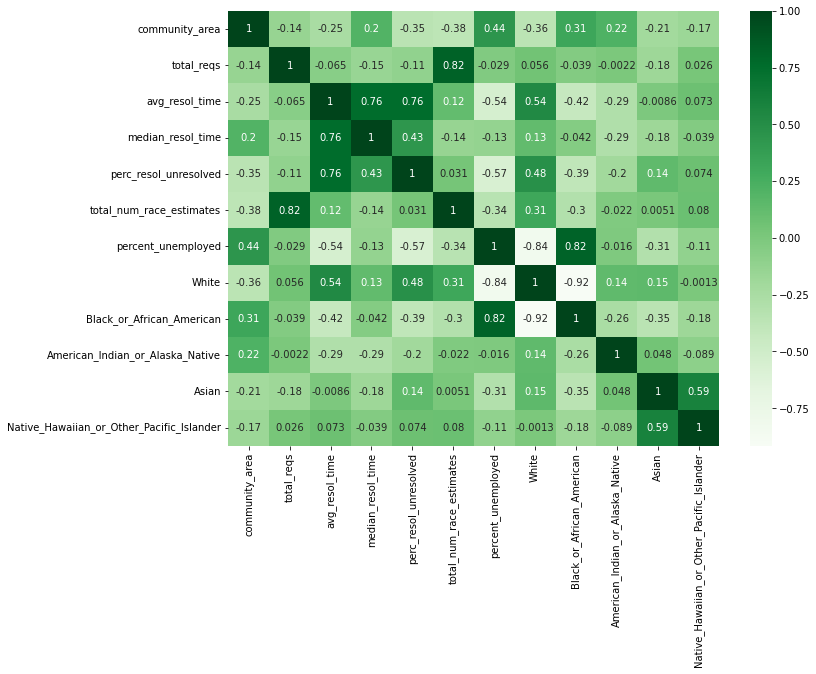

In [48]:
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

The initial overview of the median resolution time shows higher median resolution time for South Side (appox 3.5 days) and Far South East Side (appox 6.7 days) compared to the North Side (appox 2.8 days) and Central Chicago (appox 2.5 days). However, we do not want to jump to conclusions purely based on these top-level numbers. As resolution times are wildly different for different types of service requests, a great next step would be to compare the median resolution times for different service request types for these neighborhoods. 

The above high-level correlation map does not reveal any particularly interest insights, but that could be because: 
1. looking at the entire correlation map for all service request types may be masking underlying differences within service types. 

2. average resolution times are potentially skewing the overall numbers, as the many resolutions that close quickly are not weighted as heavily as they should be. 

## Some Insights from the 311 Dashboard

### Comparing number of service request based on neighborhood income level 

![Service request per 1000 vs Income range](images/scatter.png)

From the above comparison, we are able to see the average annual service requests/1000 people in the 77 community areas. The left graph's x-axis is the % of the population making up to \\$50k of annual income, and the right graph's x-axis is the percentage of the population making \\$125k-\\$200k of annual income. **We can see that in neighborhoods with a higher percentage of the population making minimal income, there are more service requests made. We see the opposite trend for high-earning neighborhoods.** 

This may be due to two factors: 
1. High earners may rely less on public infrastructure, and 
2. Better neighborhoods may just have better public infrastructure that proactively deals with issues without having to be addressed by its residents.

### Deep-dive into Hyde Park's service request resolution time

!["Hyde Park's service request resolution time"](images/bar_chart.png)

From the above visualization, we are able to observe two important things. 
1. In Hyde Park, 2020 seemed to witness a peak in the % of service requests resolved in less than 1 hour, whereas most of 2019's service requests were resolved in 1-3 months. One hypothesis is that this may be an impact of the pandemic, where actually working on a lot of these requests were unfeasible and hence marked "resolved" very quickly. Further deep dive into service request types may enhance our understanding of these results. 

2. Compared to Chicago as a whole, Hyde Park's median request resolution time is now on par, as opposed to the lag in 2019. 